# __Pizza or Not Pizza?__

# _Credits_
## Johann Pineda:
[theonejohann - Overview](https://github.com/theonejohann)

[Johann Pineda LinkedIn](https://www.linkedin.com/in/johann-pineda-97992a235/)

---

## Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pizza-not-pizza/pizza_not_pizza/food101_subset.py
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2374305.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2415437.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1123352.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2294128.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/215349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/938244.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/444123.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/884964.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/2394770.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/901984.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/117282.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1227349.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/1743531.jpg
/kaggle/input/pizza-not-pizza/pizza_not_pizza/not_pizza/21

In [5]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Data

### Preproccessing

In [15]:
batch_size = 32
img_height = 180
img_width = 180

In [16]:
class_names = ["Not Pizza", "Pizza"]

In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "../input/pizza-not-pizza/pizza_not_pizza",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print(train_ds.class_names)

Found 1966 files belonging to 2 classes.
Using 1573 files for training.
['not_pizza', 'pizza']


In [26]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "../input/pizza-not-pizza/pizza_not_pizza",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

print(val_ds.class_names)

Found 1966 files belonging to 2 classes.
Using 393 files for validation.
['not_pizza', 'pizza']


In [27]:
from matplotlib import pyplot as plt

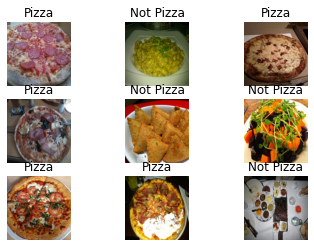

In [28]:
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Model & Augmentation

In [31]:
from tensorflow import keras
from tensorflow.keras import layers

In [33]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.8),
    layers.RandomZoom(0.8),
    layers.RandomContrast(0.1), 
  ]
)

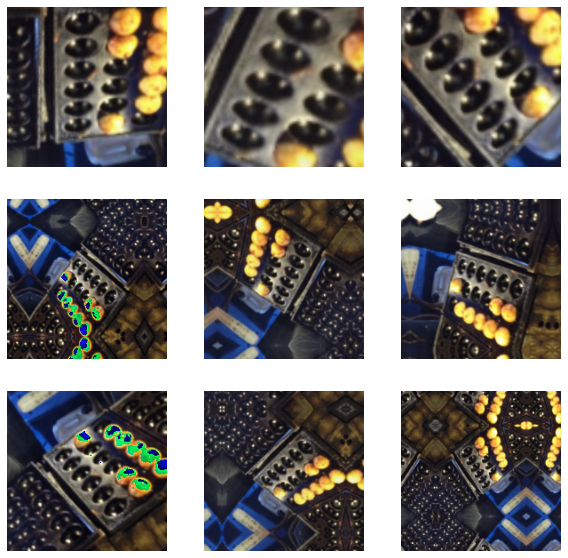

wandb: Network error (ReadTimeout), entering retry loop.


In [34]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [35]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [37]:
normalization_layer = layers.Rescaling(1./255)

In [39]:
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 10,
  "batch_size": 32
}

# ... Define a model
num_classes = len(class_names)

model = keras.Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [40]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [42]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[WandbCallback()]
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
2022-07-21 17:18:13.764526: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2022-07-21 17:18:13.764733: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-07-21 17:18:13.769072: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:1137] Optimization results for grappler item: graph_to_optimize
  function_optimizer: function_optimizer did nothing. time = 0.008ms.
  function_optimizer: function_optimizer did nothing. time = 0.001ms.



Epoch 1/10
50/50 [==============================] - 14s 241ms/step - loss: 0.7370 - accuracy: 0.5626 - val_loss: 0.6556 - val_accuracy: 0.6081
Epoch 2/10
50/50 [==============================] - 12s 246ms/step - loss: 0.6255 - accuracy: 0.6618 - val_loss: 0.6151 - val_accuracy: 0.6667
Epoch 3/10
50/50 [==============================] - 11s 226ms/step - loss: 0.5694 - accuracy: 0.7203 - val_loss: 0.5928 - val_accuracy: 0.7201
Epoch 4/10
50/50 [==============================] - 11s 224ms/step - loss: 0.5124 - accuracy: 0.7572 - val_loss: 0.5472 - val_accuracy: 0.7226
Epoch 5/10
50/50 [==============================] - 11s 226ms/step - loss: 0.4172 - accuracy: 0.8118 - val_loss: 0.5336 - val_accuracy: 0.7354
Epoch 6/10
50/50 [==============================] - 12s 243ms/step - loss: 0.3572 - accuracy: 0.8449 - val_loss: 0.5269 - val_accuracy: 0.7506
Epoch 7/10
50/50 [==============================] - 11s 224ms/step - loss: 0.3056 - accuracy: 0.8830 - val_loss: 0.6325 - val_accuracy: 0.7277

In [45]:
import matplotlib.image as mpimg


In [52]:
test_img_pizza = "../input/pizza-not-pizza/pizza_not_pizza/pizza/1001116.jpg"
test_img_not_pizza = "../input/pizza-not-pizza/pizza_not_pizza/not_pizza/1005746.jpg"

[[-3.9116848  3.7080336]]
tf.Tensor([4.904393e-04 9.995096e-01], shape=(2,), dtype=float32)
<class 'numpy.ndarray'>
[1]


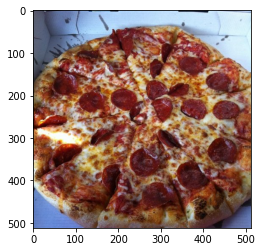

This image most likely belongs to Pizza with a 99.95 percent confidence.


In [46]:
img = tf.keras.utils.load_img(
    test_img, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(score)

# ['With_mask', 'Without_mask']
classes = predictions.argmax(axis=-1)
print(type(classes))
print(classes)

img = mpimg.imread(test_img)
imgplot = plt.imshow(img)
plt.show()
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

[[ 0.9165591 -1.5345649]]
tf.Tensor([0.92064357 0.07935639], shape=(2,), dtype=float32)
<class 'numpy.ndarray'>
[0]


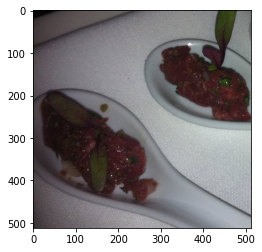

This image most likely belongs to Not Pizza with a 92.06 percent confidence.


In [53]:
img = tf.keras.utils.load_img(
    test_img_not_pizza, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(predictions)
print(score)

# ['With_mask', 'Without_mask']
classes = predictions.argmax(axis=-1)
print(type(classes))
print(classes)

img = mpimg.imread(test_img_not_pizza)
imgplot = plt.imshow(img)
plt.show()
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [54]:
model.save("PizzaClassifier.h5")